<a href="https://colab.research.google.com/github/sean311/MusicGenerator/blob/main/LSTM_Transformer_NetFlow_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM + Transformer for NetFlow Anomaly Detection
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv


In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/TrafficLabelling

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ls: cannot access '/content/drive/MyDrive/TrafficLabelling': No such file or directory


In [11]:
from google.colab import drive
drive.mount('/content/drive')

# Read dataset from your Google Drive
df = pd.read_csv(r'/content/drive/MyDrive/TrafficLabelling/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', encoding='ISO-8859-1')
df = df.dropna().drop_duplicates()
df[' Label'] = df[' Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-11-1d3da5a3c7fd>:5: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'/content/drive/MyDrive/TrafficLabelling/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', encoding='ISO-8859-1')


In [17]:
# 清除欄位名稱空白（確保能找到 Label）
df.columns = df.columns.str.strip()

# 將 Label 轉成數值
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

# 特徵欄位
features = df.select_dtypes(include=[np.number]).drop(columns=['Label'])

# 清除 inf 和 NaN
features = features.replace([np.inf, -np.inf], np.nan)
features = features.dropna()

# 對應刪除 df 的資料列
df = df.loc[features.index]

# 標準化
scaler = StandardScaler()
X = scaler.fit_transform(features)
y = df['Label'].values

# 建立時間序列資料
SEQ_LEN = 10
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X, y, SEQ_LEN)

# 切分訓練與測試集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [18]:
# LSTM + Transformer Model
input_layer = layers.Input(shape=(SEQ_LEN, X_train.shape[2]))
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(input_layer)
attention = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
attention = layers.LayerNormalization()(attention + x)
ffn = layers.Dense(128, activation='relu')(attention)
transformer_out = layers.LayerNormalization()(ffn + attention)
x = layers.GlobalAveragePooling1D()(transformer_out)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 80)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 10, 128)   │     74,240 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │    131,968 │ bidirectional[0]… │
│ (MultiHeadAttentio… │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 128)   │          0 │ multi_head_atten… │
│                     │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 128)   │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 128)   │          0 │ dense[0][0],      │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 231,553 (904.50 KB)

 Trainable params: 231,553 (904.50 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Training
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64,
                    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/10
1703/1703 ━━━━━━━━━━━━━━━━━━━━ 116s 65ms/step - accuracy: 0.9985 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 1.1577e-06
Epoch 2/10
1703/1703 ━━━━━━━━━━━━━━━━━━━━ 108s 63ms/step - accuracy: 1.0000 - loss: 8.1516e-07 - val_accuracy: 1.0000 - val_loss: 2.2810e-07
Epoch 3/10
1703/1703 ━━━━━━━━━━━━━━━━━━━━ 144s 64ms/step - accuracy: 1.0000 - loss: 1.7722e-07 - val_accuracy: 1.0000 - val_loss: 6.9835e-08
Epoch 4/10
1703/1703 ━━━━━━━━━━━━━━━━━━━━ 135s 60ms/step - accuracy: 1.0000 - loss: 5.6392e-08 - val_accuracy: 1.0000 - val_loss: 2.8548e-08
Epoch 5/10
1703/1703 ━━━━━━━━━━━━━━━━━━━━ 140s 59ms/step - accuracy: 1.0000 - loss: 2.4954e-08 - val_accuracy: 1.0000 - val_loss: 1.5852e-08
Epoch 6/10
1703/1703 ━━━━━━━━━━━━━━━━━━━━ 145s 61ms/step - accuracy: 1.0000 - loss: 1.4279e-08 - val_accuracy: 1.0000 - val_loss: 1.0102e-08
Epoch 7/10
1703/1703 ━━━━━━━━━━━━━━━━━━━━ 144s 62ms/step - accuracy: 1.0000 - loss: 9.1870e-09 - val_accuracy: 1.0000 - val_loss: 6.9322e-09
Epoch 8/10
1703/1

1064/1064 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     34044

    accuracy                           1.00     34044
   macro avg       1.00      1.00      1.00     34044
weighted avg       1.00      1.00      1.00     34044



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


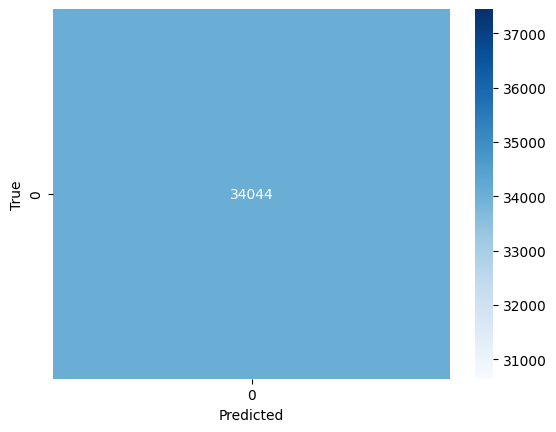

In [20]:
# Evaluation
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [21]:
print(df['Label'].value_counts())

Label
1    170230
Name: count, dtype: int64


LSTM + Transformer for NetFlow Anomaly Detection
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
